### **ENVIRONMENT SETUP**

In [ ]:
# ! rm -r data*
# ! wget http://argumentation.bplaced.net/arguana-data/dagstuhl-15512-argquality-corpus-v2.zip
# ! unzip dagstuhl-15512-argquality-corpus-v2.zip
# ! rm *.zip
# ! rm -r __MACOSX
# ! mv dagstuhl-15512-argquality-corpus-v2 data

In [ ]:
! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

### **IMPORT LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

### **IMPORT DATA**

In [ ]:
df = pd.read_csv("data/dagstuhl-15512-argquality-corpus-annotated.csv", sep='\t', encoding_errors="ignore")

In [ ]:
df

,annotator,argumentative,overall quality,local acceptability,appropriateness,arrangement,clarity,cogency,effectiveness,global acceptability,...,global sufficiency,reasonableness,local relevance,credibility,emotional appeal,sufficiency,argument,#id,issue,stance
0,1,y,1 (Low),1 (Low),1 (Low),1 (Low),2 (Average),1 (Low),1 (Low),1 (Low),...,1 (Low),1 (Low),1 (Low),1 (Low),1 (Low),1 (Low),"it is true that bottled water is a waste, but ...",arg219250,ban-plastic-water-bottles,no-bad-for-the-economy
1,2,y,1 (Low),3 (High),2 (Average),2 (Average),3 (High),1 (Low),1 (Low),3 (High),...,1 (Low),2 (Average),2 (Average),2 (Average),2 (Average),1 (Low),"it is true that bottled water is a waste, but ...",arg219250,ban-plastic-water-bottles,no-bad-for-the-economy
2,3,y,2 (Average),2 (Average),2 (Average),2 (Average),2 (Average),2 (Average),2 (Average),2 (Average),...,2 (Average),2 (Average),3 (High),2 (Average),1 (Low),2 (Average),"it is true that bottled water is a waste, but ...",arg219250,ban-plastic-water-bottles,no-bad-for-the-economy
3,1,y,2 (Average),3 (High),2 (Average),2 (Average),2 (Average),2 (Average),2 (Average),2 (Average),...,2 (Average),2 (Average),3 (High),3 (High),2 (Average),2 (Average),Most Americans on average recycle 86-88% of th...,arg219293,ban-plastic-water-bottles,no-bad-for-the-economy
4,2,y,1 (Low),2 (Average),1 (Low),2 (Average),2 (Average),1 (Low),1 (Low),2 (Average),...,1 (Low),1 (Low),2 (Average),2 (Average),2 (Average),1 (Low),Most Americans on average recycle 86-88% of th...,arg219293,ban-plastic-water-bottles,no-bad-for-the-economy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2,y,2 (Average),2 (Average),3 (High),2 (Average),2 (Average),1 (Low),1 (Low),3 (High),...,1 (Low),2 (Average),2 (Average),2 (Average),2 (Average),1 (Low),Raffles neglected Singapore when he went aroun...,arg168822,william-farquhar-ought-to-be-honoured-as-the-r...,yes-of-course
956,3,y,2 (Average),2 (Average),2 (Average),2 (Average),2 (Average),2 (Average),2 (Average),2 (Average),...,2 (Average),2 (Average),3 (High),2 (Average),2 (Average),2 (Average),Raffles neglected Singapore when he went aroun...,arg168822,william-farquhar-ought-to-be-honoured-as-the-r...,yes-of-course
957,1,y,2 (Average),2 (Average),2 (Average),2 (Average),1 (Low),2 (Average),2 (Average),2 (Average),...,2 (Average),2 (Average),3 (High),2 (Average),2 (Average),2 (Average),"Raffles doesn't care about the citizens, doesn...",arg168834,william-farquhar-ought-to-be-honoured-as-the-r...,yes-of-course
958,2,y,2 (Average),2 (Average),3 (High),2 (Average),3 (High),1 (Low),2 (Average),2 (Average),...,1 (Low),2 (Average),2 (Average),2 (Average),3 (High),1 (Low),"Raffles doesn't care about the citizens, doesn...",arg168834,william-farquhar-ought-to-be-honoured-as-the-r...,yes-of-course


In [ ]:
print(f"Number of annotations = {len(df['argument'])}")
print(f"Number of unique arguements = {len(np.unique(df['argument']))}") #each argument was scored by 3 annotators

print(f"Number of unique issue = {len(np.unique(df['issue']))}")  #There are a total of 16 issues
print(f"Number of unique stance = {len(np.unique(df['stance']))}") # Each issue has on an avg 2 stance (positive and negative)

Number of annotations = 935
Number of unique arguements = 316
Number of unique issue = 16
Number of unique stance = 28


### **Data preprocessing**

In [ ]:
# Removing non-arguments from the dataframe

df.drop(df[df['argumentative'] == 'n'].index, axis=0, inplace=True)

print(f"Number of annotations = {len(df['argument'])}")
print(f"Number of unique arguements = {len(np.unique(df['argument']))}")

Number of annotations = 935
Number of unique arguements = 316


In [ ]:
# Convert Quality Metrics into numerical values

quality_map = {
    "1 (Low)": 1,
    "2 (Average)": 2,
    "3 (High)": 3,
}

quality_metrics = ["overall quality", "local acceptability", "appropriateness", "arrangement", "clarity", "cogency",
                   "effectiveness", "global acceptability", "global relevance", "global sufficiency", "reasonableness",
                   "local relevance", "credibility", "emotional appeal", "sufficiency"]

for col in quality_metrics:
    df[col] = df[col].map(quality_map)

In [ ]:
df

,annotator,argumentative,overall quality,local acceptability,appropriateness,arrangement,clarity,cogency,effectiveness,global acceptability,...,global sufficiency,reasonableness,local relevance,credibility,emotional appeal,sufficiency,argument,#id,issue,stance
0,1,y,1,1,1,1,2,1,1,1,...,1,1,1,1,1,1,"it is true that bottled water is a waste, but ...",arg219250,ban-plastic-water-bottles,no-bad-for-the-economy
1,2,y,1,3,2,2,3,1,1,3,...,1,2,2,2,2,1,"it is true that bottled water is a waste, but ...",arg219250,ban-plastic-water-bottles,no-bad-for-the-economy
2,3,y,2,2,2,2,2,2,2,2,...,2,2,3,2,1,2,"it is true that bottled water is a waste, but ...",arg219250,ban-plastic-water-bottles,no-bad-for-the-economy
3,1,y,2,3,2,2,2,2,2,2,...,2,2,3,3,2,2,Most Americans on average recycle 86-88% of th...,arg219293,ban-plastic-water-bottles,no-bad-for-the-economy
4,2,y,1,2,1,2,2,1,1,2,...,1,1,2,2,2,1,Most Americans on average recycle 86-88% of th...,arg219293,ban-plastic-water-bottles,no-bad-for-the-economy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2,y,2,2,3,2,2,1,1,3,...,1,2,2,2,2,1,Raffles neglected Singapore when he went aroun...,arg168822,william-farquhar-ought-to-be-honoured-as-the-r...,yes-of-course
956,3,y,2,2,2,2,2,2,2,2,...,2,2,3,2,2,2,Raffles neglected Singapore when he went aroun...,arg168822,william-farquhar-ought-to-be-honoured-as-the-r...,yes-of-course
957,1,y,2,2,2,2,1,2,2,2,...,2,2,3,2,2,2,"Raffles doesn't care about the citizens, doesn...",arg168834,william-farquhar-ought-to-be-honoured-as-the-r...,yes-of-course
958,2,y,2,2,3,2,3,1,2,2,...,1,2,2,2,3,1,"Raffles doesn't care about the citizens, doesn...",arg168834,william-farquhar-ought-to-be-honoured-as-the-r...,yes-of-course


In [ ]:
# Compute averages for the Quality Metrics

df_avg = []

arguments = np.unique(df['argument'])

for arg in arguments:
    new_df = df[df['argument'] == arg]
    new_dict = {
        "argumentative": new_df['argumentative'].iloc[0],
    }
    for col in quality_metrics:
        new_dict[col] = np.average(new_df[col])
    new_dict['argument'] = new_df['argument'].iloc[0]
    new_dict['#id'] = new_df['#id'].iloc[0]
    new_dict['issue'] = new_df['issue'].iloc[0]
    new_dict['stance'] = new_df['stance'].iloc[0]
    df_avg.append(new_dict)

df_avg = pd.DataFrame(df_avg)
df_avg

,argumentative,overall quality,local acceptability,appropriateness,arrangement,clarity,cogency,effectiveness,global acceptability,global relevance,global sufficiency,reasonableness,local relevance,credibility,emotional appeal,sufficiency,argument,#id,issue,stance
0,y,1.666667,1.666667,2.333333,2.000000,2.333333,1.333333,1.000000,1.333333,2.000000,1.000000,1.000000,2.333333,1.000000,2.000000,1.333333,"""Debates are based on convincing evidence. The...",28068,evolution-vs-creation,creation
1,y,1.333333,1.333333,2.666667,2.000000,2.666667,1.666667,1.333333,1.666667,1.333333,1.333333,1.333333,2.333333,2.000000,2.333333,1.333333,"""If a women is raped"" is a good argument. Howe...",13270,pro-choice-vs-pro-life,pro-life
2,y,1.333333,2.333333,2.333333,2.000000,2.000000,1.333333,1.333333,1.666667,1.333333,1.333333,1.333333,2.000000,2.000000,2.000000,1.333333,"""The government has no place to tell a woman w...",13275,pro-choice-vs-pro-life,pro-life
3,y,1.666667,2.000000,2.333333,2.000000,2.666667,1.333333,1.333333,2.000000,1.666667,1.333333,1.666667,2.666667,2.000000,1.666667,1.333333,(I am writing this through Firefox) Emotions a...,12365,firefox-vs-internet-explorer,there-s-more-browsers-than-the-ie-firefox-is-a...
4,y,2.000000,2.333333,2.000000,1.666667,2.333333,2.000000,1.333333,2.333333,2.666667,1.333333,2.333333,3.000000,2.000000,1.666667,2.333333,1. Books don't ruin your eyes like TV. does. <...,arg585714,tv-is-better-than-books,books
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,y,1.666667,1.666667,1.666667,1.666667,2.333333,1.666667,1.333333,1.666667,2.000000,1.333333,1.666667,2.666667,1.666667,1.666667,1.333333,"yea, because even though there are many other ...",arg334959,human-growth-and-development-should-parents-us...,yes
312,y,1.000000,1.333333,2.000000,1.666667,1.666667,1.000000,1.000000,1.333333,1.666667,1.000000,1.000000,2.000000,1.333333,1.666667,1.000000,yes because if they fear getting hit than they...,arg335089,human-growth-and-development-should-parents-us...,yes
313,y,1.666667,1.666667,2.333333,1.666667,1.666667,1.666667,1.333333,1.666667,2.000000,1.333333,1.666667,2.000000,1.666667,2.000000,1.666667,"yes, i believe it's nice to have a school unif...",arg203922,is-the-school-uniform-a-good-or-bad-idea,good
314,y,1.000000,1.000000,1.333333,1.000000,1.000000,1.000000,1.000000,1.333333,1.333333,1.000000,1.000000,1.666667,1.000000,1.666667,1.000000,"yes,India has potential to lead the world.So, ...",arg596217,india-has-the-potential-to-lead-the-world,yes-for


In [ ]:
print(f"Number of annotations = {len(df_avg['argument'])}")

Number of annotations = 316


In [ ]:
# Compute total score for each argument

df_avg['total score'] = df_avg[quality_metrics].sum(axis=1)
df_avg

,argumentative,overall quality,local acceptability,appropriateness,arrangement,clarity,cogency,effectiveness,global acceptability,global relevance,...,reasonableness,local relevance,credibility,emotional appeal,sufficiency,argument,#id,issue,stance,total score
0,y,1.666667,1.666667,2.333333,2.000000,2.333333,1.333333,1.000000,1.333333,2.000000,...,1.000000,2.333333,1.000000,2.000000,1.333333,"""Debates are based on convincing evidence. The...",28068,evolution-vs-creation,creation,24.333333
1,y,1.333333,1.333333,2.666667,2.000000,2.666667,1.666667,1.333333,1.666667,1.333333,...,1.333333,2.333333,2.000000,2.333333,1.333333,"""If a women is raped"" is a good argument. Howe...",13270,pro-choice-vs-pro-life,pro-life,26.666667
2,y,1.333333,2.333333,2.333333,2.000000,2.000000,1.333333,1.333333,1.666667,1.333333,...,1.333333,2.000000,2.000000,2.000000,1.333333,"""The government has no place to tell a woman w...",13275,pro-choice-vs-pro-life,pro-life,25.666667
3,y,1.666667,2.000000,2.333333,2.000000,2.666667,1.333333,1.333333,2.000000,1.666667,...,1.666667,2.666667,2.000000,1.666667,1.333333,(I am writing this through Firefox) Emotions a...,12365,firefox-vs-internet-explorer,there-s-more-browsers-than-the-ie-firefox-is-a...,27.666667
4,y,2.000000,2.333333,2.000000,1.666667,2.333333,2.000000,1.333333,2.333333,2.666667,...,2.333333,3.000000,2.000000,1.666667,2.333333,1. Books don't ruin your eyes like TV. does. <...,arg585714,tv-is-better-than-books,books,31.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,y,1.666667,1.666667,1.666667,1.666667,2.333333,1.666667,1.333333,1.666667,2.000000,...,1.666667,2.666667,1.666667,1.666667,1.333333,"yea, because even though there are many other ...",arg334959,human-growth-and-development-should-parents-us...,yes,26.000000
312,y,1.000000,1.333333,2.000000,1.666667,1.666667,1.000000,1.000000,1.333333,1.666667,...,1.000000,2.000000,1.333333,1.666667,1.000000,yes because if they fear getting hit than they...,arg335089,human-growth-and-development-should-parents-us...,yes,20.666667
313,y,1.666667,1.666667,2.333333,1.666667,1.666667,1.666667,1.333333,1.666667,2.000000,...,1.666667,2.000000,1.666667,2.000000,1.666667,"yes, i believe it's nice to have a school unif...",arg203922,is-the-school-uniform-a-good-or-bad-idea,good,26.000000
314,y,1.000000,1.000000,1.333333,1.000000,1.000000,1.000000,1.000000,1.333333,1.333333,...,1.000000,1.666667,1.000000,1.666667,1.000000,"yes,India has potential to lead the world.So, ...",arg596217,india-has-the-potential-to-lead-the-world,yes-for,17.333333


# **Visualization**

In [ ]:
count_annotator = pd.value_counts(df['annotator'])
count_annotator

1    314
3    311
2    310
Name: annotator, dtype: int64

In [ ]:
count_stance = pd.value_counts(df['stance'])
count_stance

no                                                        90
yes                                                       90
fatherless                                                30
lousy-father                                              30
no-it-is-raffles                                          30
tv                                                        30
books                                                     30
pro-life                                                  30
pro-choice                                                30
personal-pursuit                                          30
advancing-the-common-good                                 30
good                                                      30
bad                                                       30
yes-porn-is-wrong                                         30
no-is-is-not                                              30
yes-of-course                                             30
yes-for                 

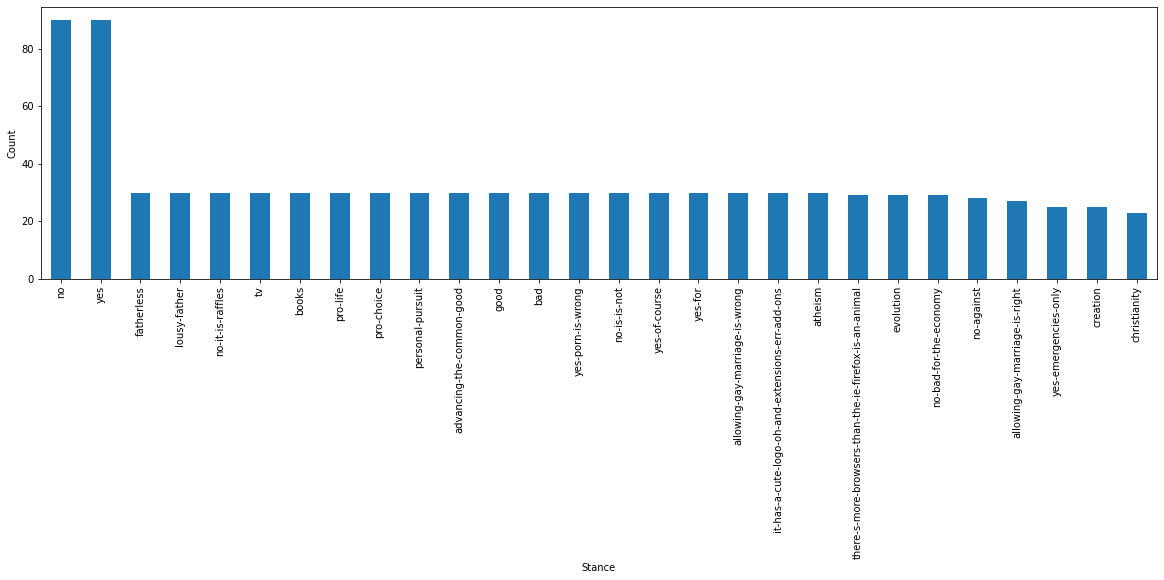

In [ ]:
fig = plt.figure(figsize = (20, 5))
 
df['stance'].value_counts().plot(kind='bar')
 
plt.ylabel("Count")
plt.xlabel("Stance")
plt.show()

In [ ]:
count_issue = pd.value_counts(df['issue'])
count_issue

human-growth-and-development-should-parents-use-spanking-as-an-option-to-discipline     60
if-your-spouse-committed-murder-and-he-or-she-confided-in-you-would-you-turn-them-in    60
is-it-better-to-have-a-lousy-father-or-to-be-fatherless                                 60
is-porn-wrong                                                                           60
is-the-school-uniform-a-good-or-bad-idea                                                60
personal-pursuit-or-advancing-the-common-good                                           60
pro-choice-vs-pro-life                                                                  60
should-physical-education-be-mandatory-in-schools                                       60
tv-is-better-than-books                                                                 60
william-farquhar-ought-to-be-honoured-as-the-rightful-founder-of-singapore              60
firefox-vs-internet-explorer                                                            59

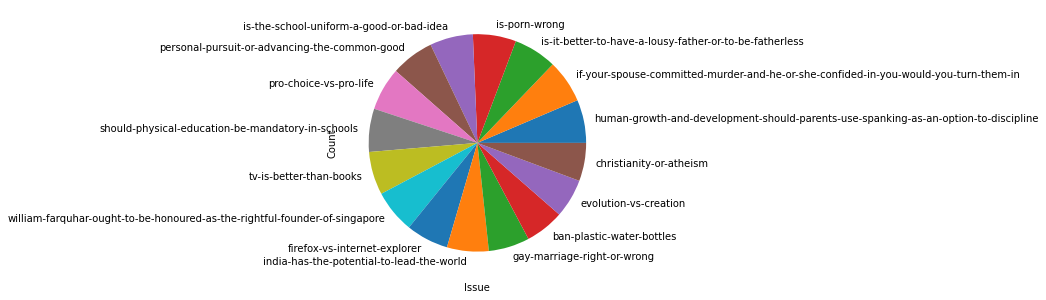

In [ ]:
fig = plt.figure(figsize = (20, 5))
 
df['issue'].value_counts().plot(kind='pie')
 
plt.ylabel("Count")
plt.xlabel("Issue")
plt.show()

In [ ]:
count_overallQuality = pd.value_counts(df['overall quality'])
count_overallQuality 

1    481
2    356
3     98
Name: overall quality, dtype: int64

In [ ]:
print("Highest total score : " + str(df_avg['total score'].max()))
print("Average total score : " + str(df_avg['total score'].mean()))
print("Lowest total score : " + str(df_avg['total score'].min()))


Highest total score : 43.0
Average total score : 26.59018987341772
Lowest total score : 15.333333333333334


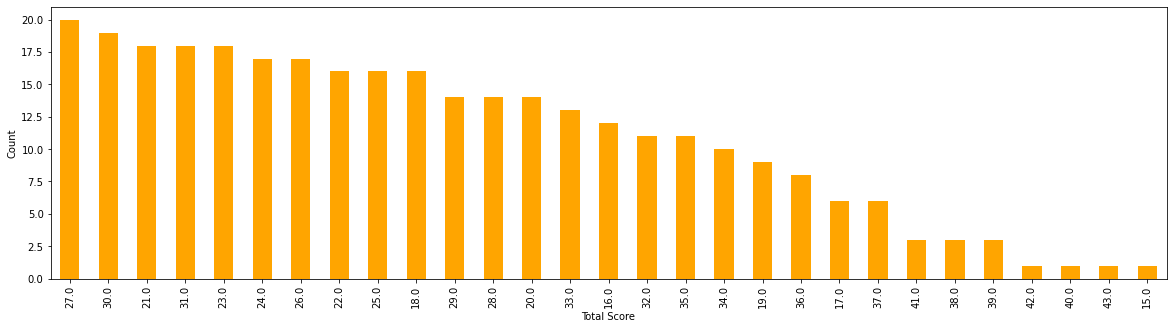

In [ ]:
total_score=round(df_avg['total score'])

fig = plt.figure(figsize = (20, 5))
 
#df['overall quality'].value_counts().plot(kind='pie',autopct='%1.2f%%')
total_score.value_counts().plot(kind='bar', color='orange')
 
plt.ylabel("Count")
plt.xlabel("Total Score")
plt.show()

# **Exploratory Data Analysis**

In [ ]:
text=df_avg['argument']
text

0      "Debates are based on convincing evidence. The...
1      "If a women is raped" is a good argument. Howe...
2      "The government has no place to tell a woman w...
3      (I am writing this through Firefox) Emotions a...
4      1. Books don't ruin your eyes like TV. does. <...
                             ...                        
311    yea, because even though there are many other ...
312    yes because if they fear getting hit than they...
313    yes, i believe it's nice to have a school unif...
314    yes,India has potential to lead the world.So, ...
315    you can get the "Foxtel Go" app on your Ipad s...
Name: argument, Length: 316, dtype: object

## Character level exploration

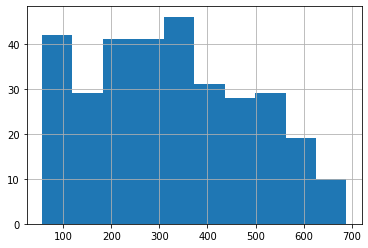

In [ ]:
#Character exploration

#number of characters present in each sentence
text.str.len().hist()

#The histogram shows that the arguments range from 1 to 700 characters 
#and generally, it is between 1 to around 690 characters.

## Word level exploration

In [ ]:
#average word length
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

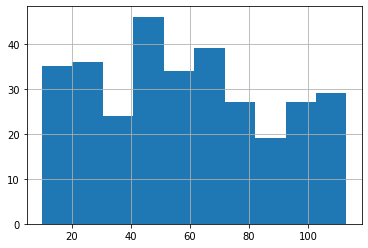

In [ ]:
plot_word_number_histogram(text)


## Top 10 stopwords used

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

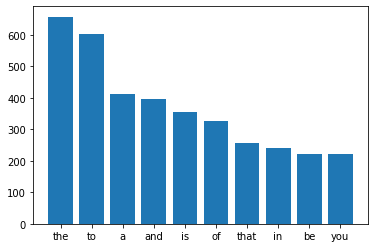

In [ ]:
plot_top_stopwords_barchart(text)

## Common words other than stopwords

In [ ]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new_ = text.str.lower()
    new = new_.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y=[], []
    for word,count in most[:60]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

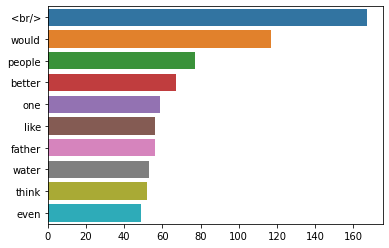

In [ ]:
plot_top_non_stopwords_barchart(text) # </br> needs to be removed

## N-gram exploration

In [ ]:
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
#from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new_ = text.str.lower()
    new= new_.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

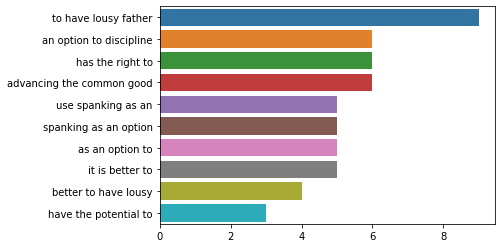

In [ ]:
plot_top_ngrams_barchart(text,4)

## Topic Modelling

In [ ]:
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
#import pyLDAvis.gensim

def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 16, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
    return vis

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(text)

In [ ]:
lda_model.show_topics()

[(5,
  '0.017*"n\'t" + 0.014*"raffle" + 0.013*"India" + 0.012*"br/" + 0.011*"world" + 0.010*"say" + 0.010*"father" + 0.008*"education" + 0.007*"need" + 0.007*"like"'),
 (12,
  '0.018*"would" + 0.012*"br/" + 0.010*"n\'t" + 0.008*"know" + 0.008*"wrong" + 0.008*"water" + 0.007*"child" + 0.007*"life" + 0.006*"The" + 0.006*"scientific"'),
 (0,
  '0.045*"br/" + 0.026*"n\'t" + 0.014*"think" + 0.011*"The" + 0.011*"would" + 0.010*"woman" + 0.007*"mean" + 0.007*"take" + 0.006*"better" + 0.006*"body"'),
 (8,
  '0.036*"Raffles" + 0.027*"Farquhar" + 0.026*"Singapore" + 0.013*"William" + 0.013*"br/" + 0.010*"one" + 0.008*"founder" + 0.007*"also" + 0.007*"better" + 0.007*"way"'),
 (10,
  '0.020*"br/" + 0.017*"school" + 0.014*"n\'t" + 0.010*"child" + 0.010*"people" + 0.008*"would" + 0.008*"education" + 0.008*"like" + 0.007*"book" + 0.006*"help"'),
 (15,
  '0.019*"uniform" + 0.017*"school" + 0.017*"n\'t" + 0.016*"would" + 0.015*"br/" + 0.006*"also" + 0.006*"always" + 0.006*"marriage" + 0.006*"The" + 0.

In [ ]:
plot_lda_vis(lda_model, bow_corpus, dic)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.150560 -0.102307       1        1  18.143425
14    -0.095562  0.118159       2        1  12.671265
0     -0.105110  0.045950       3        1   8.715956
10    -0.027277  0.027262       4        1   8.399446
12    -0.015591  0.051359       5        1   7.848902
11    -0.059725 -0.063854       6        1   6.601389
7      0.025049  0.053222       7        1   5.888292
15    -0.012580  0.078154       8        1   4.929435
2      0.072579  0.068856       9        1   4.287080
8      0.127583  0.002707      10        1   4.114616
1      0.008250 -0.094854      11        1   3.867421
5      0.019098 -0.051561      12        1   3.752505
4      0.011126 -0.072958      13        1   3.524678
9      0.052145  0.012079      14        1   3.248997
3      0.079267 -0.018277      15        1   2.625297
13     0.071310 -0.053938      16        1   1.381295, topic_info=        Term     Freq      Total Category  logprob  loglift
374   father  61.0000  61.000000  Default  30.0000  30.0000
381    lousy  31.0000  31.000000  Default  29.0000  29.0000
343  Raffles  23.0000  23.000000  Default  28.0000  28.0000
112   better  55.0000  55.000000  Default  27.0000  27.0000
311    India  29.0000  29.000000  Default  26.0000  26.0000
..       ...      ...        ...      ...      ...      ...
191      get   0.4596  34.505784  Topic16  -5.6459  -0.0364
410     made   0.4596  10.254739  Topic16  -5.6459   1.1770
424     year   0.4596  17.843789  Topic16  -5.6459   0.6231
426      NOT   0.4596   5.740653  Topic16  -5.6459   1.7572
457   reason   0.4596  16.292903  Topic16  -5.6459   0.7140

[1080 rows x 6 columns], token_table=      Topic      Freq                                               Term
term                                                                    
1915      9  0.712010  //www.treehugger.com/culture/23-percent-of-ame...
2173      8  0.697185                                               1822
2008     13  0.733435                                               1984
2557      1  0.801277                                               2001
1560     14  0.734094                                               2GBs
...     ...       ...                                                ...
1200      5  0.232823                                                yes
1200      8  0.232823                                                yes
1200      9  0.116411                                                yes
339      11  0.725395                                                yet
1309     10  0.710180                                           youngest

[2084 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 15, 1, 11, 13, 12, 8, 16, 3, 9, 2, 6, 5, 10, 4, 14])

## Word clouds

In [ ]:
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


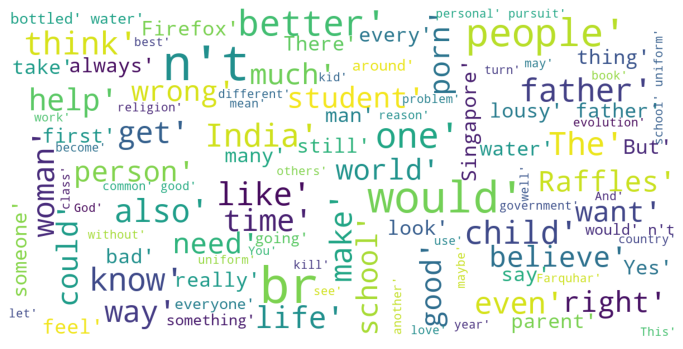

In [ ]:
plot_wordcloud(text)